In [ ]:
!nvidia-smi

Sat Jun  8 03:29:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-08 03:29:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   169MB/s    in 0.9s    

2024-06-08 03:30:00 (169 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240608-033013
Epoch 1/5
24/24 [==============================] - 22s 601ms/step - loss: 1.8353 - accuracy: 0.3987 - val_loss: 1.1379 - val_accuracy: 0.6340
Epoch 2/5
24/24 [==============================] - 10s 438ms/step - loss: 0.8866 - accuracy: 0.7320 - val_loss: 0.8244 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 11s 457ms/step - loss: 0.6213 - accuracy: 0.8227 - val_loss: 0.7530 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 11s 492ms/step - loss: 0.4784 - accuracy: 0.8747 - val_loss: 0.6895 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 11s 458ms/step - loss: 0.3797 - accuracy: 0.9160 - val_loss: 0.6833 - val_accuracy: 0.7728


In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

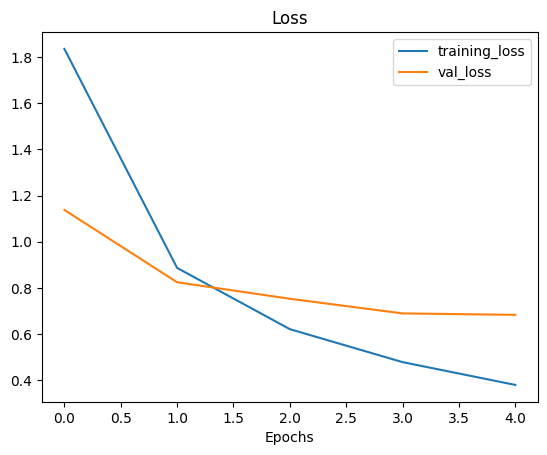

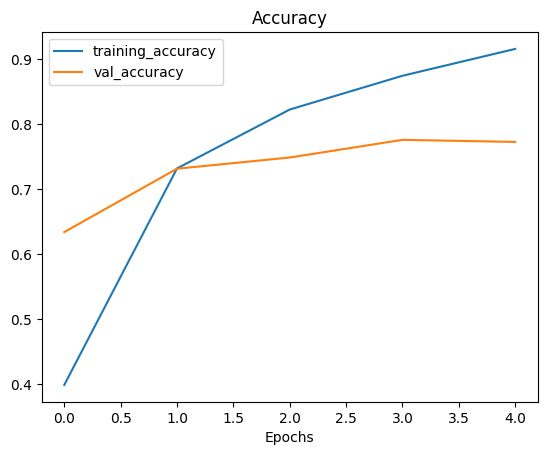

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240608-033141
Epoch 1/5
24/24 [==============================] - 24s 548ms/step - loss: 1.9185 - accuracy: 0.3867 - val_loss: 1.3325 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 10s 431ms/step - loss: 1.0695 - accuracy: 0.7813 - val_loss: 0.8791 - val_accuracy: 0.8288
Epoch 3/5
24/24 [==============================] - 10s 434ms/step - loss: 0.7546 - accuracy: 0.8467 - val_loss: 0.7030 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 10s 438ms/step - loss: 0.6059 - accuracy: 0.8760 - val_loss: 0.6127 - val_accuracy: 0.8560
Epoch 5/5
24/24 [==============================] - 10s 414ms/step - loss: 0.5103 - accuracy: 0.8960 - val_loss: 0.5597 - val_accuracy: 0.8644


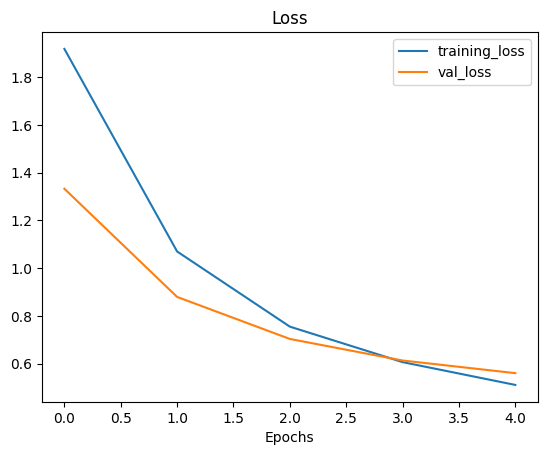

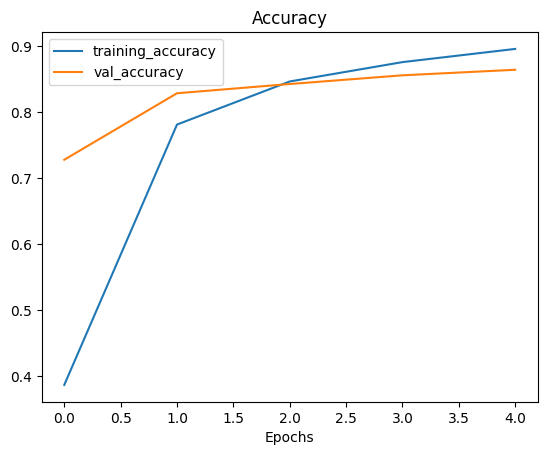

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


Enter the path of the image you want to predict: /content/10_food_classes_10_percent/test/chicken_curry/101833.jpg
1/1 [==============================] - 2s 2s/step
Top 3 predictions:
1. chicken_curry: 59.10%
2. ramen: 25.32%
3. steak: 7.38%


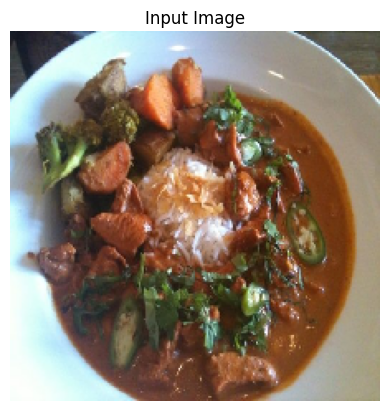

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get image from user
image_path = input("Enter the path of the image you want to predict: ")

# Read and preprocess the image
image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SHAPE)
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = image_array / 255.0  # Normalize the image
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Make predictions using the EfficientNet model
predictions = efficientnet_model.predict(image_array)

# Get the top 3 predicted classes
top_3_indices = np.argsort(predictions[0])[::-1][:3]

# Get the class names (ensure train_data_10_percent.class_indices is available)
class_names = train_data_10_percent.class_indices  # Replace with your class indices
class_names = list(class_names.keys())

# Print the top 3 predicted classes and their probabilities
print("Top 3 predictions:")
for i in range(3):
    class_name = class_names[top_3_indices[i]]
    probability = predictions[0][top_3_indices[i]] * 100
    print(f"{i+1}. {class_name}: {probability:.2f}%")

# Display the image
plt.imshow(tf.keras.preprocessing.image.array_to_img(image_array[0]))
plt.axis('off')
plt.title("Input Image")
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get image from user
image_path = input("Enter the path of the image you want to predict: ")

# Read and preprocess the image
image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SHAPE)
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = image_array / 255.0  # Normalize the image
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Make predictions using the EfficientNet model
predictions = resnet_model.predict(image_array)

# Get the top 3 predicted classes
top_3_indices = np.argsort(predictions[0])[::-1][:3]

# Get the class names (ensure train_data_10_percent.class_indices is available)
class_names = train_data_10_percent.class_indices  # Replace with your class indices
class_names = list(class_names.keys())

# Print the top 3 predicted classes and their probabilities
print("Top 3 predictions:")
for i in range(3):
    class_name = class_names[top_3_indices[i]]
    probability = predictions[0][top_3_indices[i]] * 100
    print(f"{i+1}. {class_name}: {probability:.2f}%")

# Display the image
plt.imshow(tf.keras.preprocessing.image.array_to_img(image_array[0]))
plt.axis('off')
plt.title("Input Image")
plt.show()